### Description of sets

    1) Human ECoG:        20 subj * 32/64 channels * time
                          [subj][ch][data]
                      
    2) Monkey ECoG:       4 subj * 128 channels * epochs * time
                          [subj][ch][ep][data]
                          
    3) Hippocampal Rat:   3 subj * 2-8 days * 30 channels * epoch * time
                          [subj][day][ch][ep][data]
        

### Imports

In [1]:
# Imports
import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model


# imports own modules
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\Code\distinguish_pac')





### Load data

In [2]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
datastruct = np.load('data_dict.npy',  allow_pickle=True).item()
features_df = np.load('features_df.npy', allow_pickle=True).item()

# Distributions of the datasets

In [3]:
features_df['human'].columns

Index(['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym'],
      dtype='object')

C:\Users\jaapv\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jaapv\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


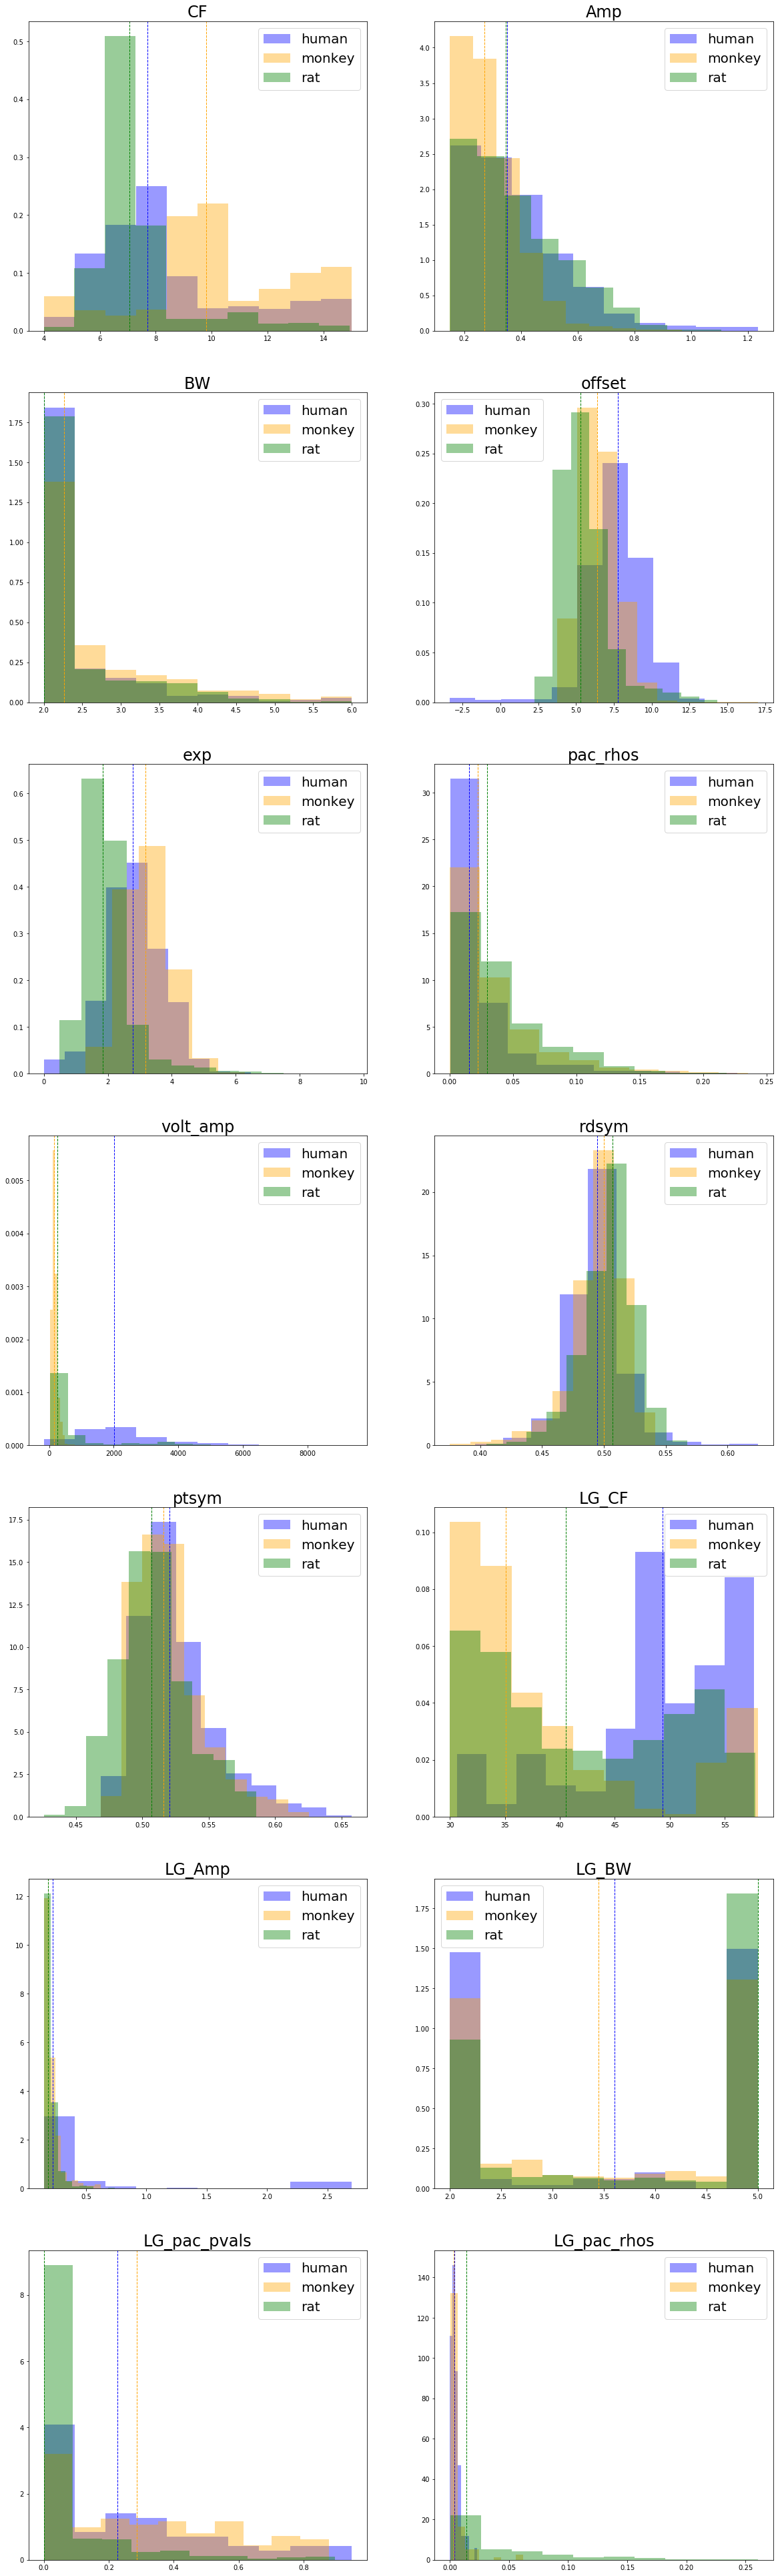

In [4]:
hist_list = ['CF', 'Amp', 'BW', 'offset', 'exp', 'pac_rhos', 
       'volt_amp', 'rdsym', 'ptsym', 'LG_CF', 'LG_Amp', 'LG_BW',
            'LG_pac_pvals', 'LG_pac_rhos']


kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=10)

plt.figure(figsize=(20,70))
for ii in range(len(hist_list)): 

    # subplots 4x3
    plt.subplot(7,2,ii+1)

    
    plt.hist(features_df['human'][hist_list[ii]], color='blue', label='human', **kwargs)
    plt.hist(features_df['monkey'][hist_list[ii]], color='orange', label='monkey', **kwargs)
    plt.hist(features_df['rat'][hist_list[ii]], color='green', label='rat', **kwargs)

    
    plt.axvline(np.nanmedian(features_df['human'][hist_list[ii]]), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(features_df['monkey'][hist_list[ii]]), color='orange', linestyle='dashed', linewidth=1)
    plt.axvline(np.nanmedian(features_df['rat'][hist_list[ii]]), color='green', linestyle='dashed', linewidth=1)
    plt.legend(fontsize=20)
    plt.title(hist_list[ii], size=24)
    

 <div class="alert alert-success">
There seem to be not so much differences in the distribution between datasets. There are differences in neural activity, such as PSD (aperiodic and periodic components) and in the amplitudes of the signal. But that does not seem to have much effect on the PAC measures and symmetry waveform shape
</div>

# Average correlation between features across datasets

In [21]:
corr_mat_human = features_df['human'][['pac_rhos', 'CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym', 'ptsym', 'LG_CF', 'LG_Amp', 'LG_BW', 'LG_pac_rhos']].copy().corr()
corr_mat_monkey = features_df['monkey'][['pac_rhos', 'CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym', 'ptsym', 'LG_CF', 'LG_Amp', 'LG_BW', 'LG_pac_rhos']].copy().corr()
corr_mat_rat = features_df['rat'][['pac_rhos', 'CF', 'Amp', 'BW', 'offset', 'exp',
                                'volt_amp', 'rdsym', 'ptsym', 'LG_CF', 'LG_Amp', 'LG_BW', 'LG_pac_rhos']].copy().corr()

Text(0.5, 1, 'Average correlation between features across datasets')

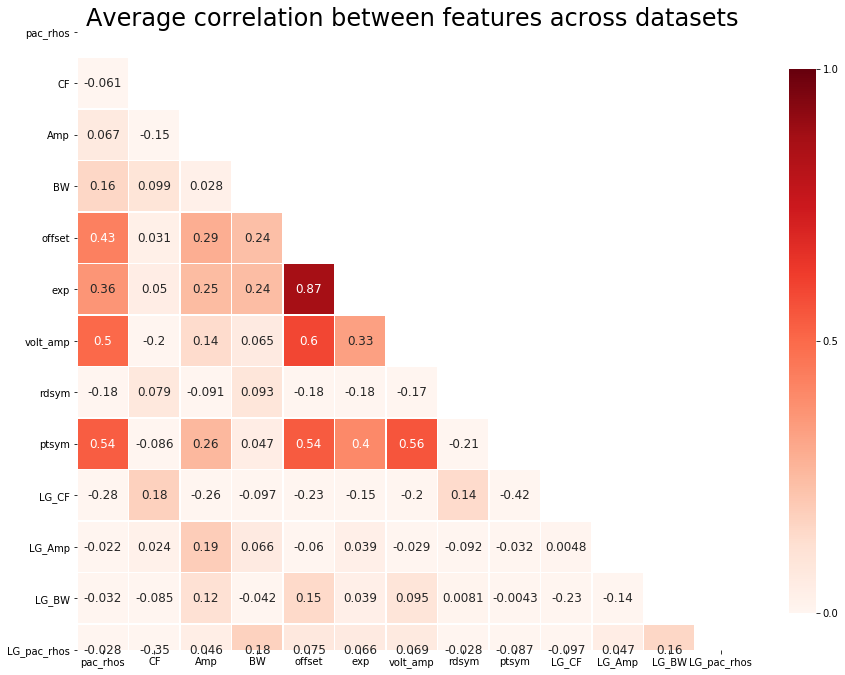

In [22]:
corr_average = (corr_mat_human + corr_mat_monkey + corr_mat_rat) / 3

mask = np.zeros_like(corr_average, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))

heatmap = sns.heatmap(corr_average,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'Reds',
                      cbar_kws = {'shrink': .5,
                                'ticks' : [0, 0.5, 1]},
                      vmin = 0,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_average.columns, rotation = 0)
ax.set_xticklabels(corr_average.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.title('Average correlation between features across datasets', size=24)

# Percentages of PAC per dataset

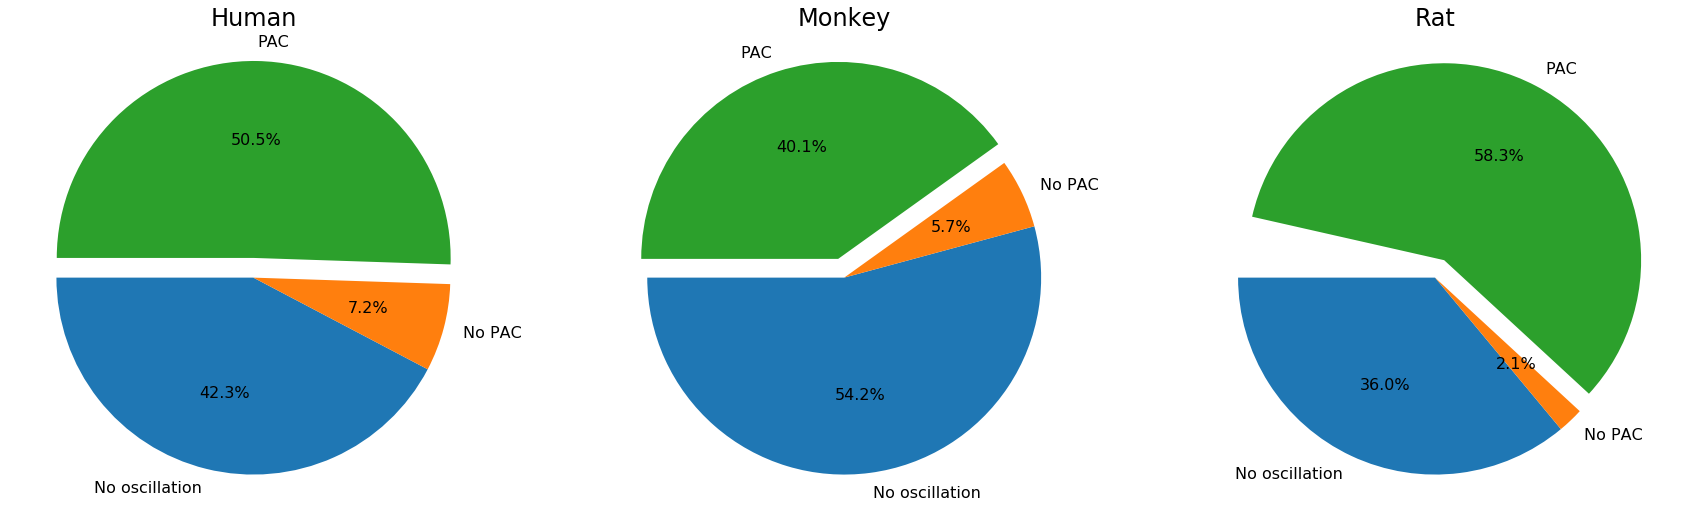

In [7]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'No oscillation', 'No PAC', 'PAC'
sizes = [[1 - (features_df['human']['CF'].count()/ len(features_df['human'])),
         len(features_df['human'][features_df['human']['pac_presence']==0]) / len(features_df['human']),
         len(features_df['human'][features_df['human']['pac_presence']==1]) / len(features_df['human'])],
         
         [1 - (features_df['monkey']['CF'].count()/ len(features_df['monkey'])),
         len(features_df['monkey'][features_df['monkey']['pac_presence']==0]) / len(features_df['monkey']),
         len(features_df['monkey'][features_df['monkey']['pac_presence']==1]) / len(features_df['monkey'])],

         [1 - (features_df['rat']['CF'].count()/ len(features_df['rat'])),
         len(features_df['rat'][features_df['rat']['pac_presence']==0]) / len(features_df['rat']),
         len(features_df['rat'][features_df['rat']['pac_presence']==1]) / len(features_df['rat'])]]
        
explode = (0, 0, 0.1)

titles = ['Human', 'Monkey', 'Rat']

plt.figure(figsize=(30,10))
for ii in range(len(sizes)): 

    # subplots 4x3
    plt.subplot(1,3,ii+1)
                
    plt.pie(sizes[ii], explode=explode, labels=labels, textprops={'size': 16}, autopct='%1.1f%%',
            shadow=False, startangle=180)
   # plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(titles[ii], size=24)


 <div class="alert alert-success">
Rat data don't fully add up due to some manual changes in dataframe (but will be fixed in later version). The number of channels with PAC after resampling is quite the same, even while the number of channels with an oscillation differ. 
</div>

 <div class="alert alert-success">
Hard to compare with earlier histograms with this visualisation, but main conclusion: The distributions of features of channels with significant PAC after resampling almost do not differ from the distributions that also include no oscillations and no sign. PAC. 
</div>

#  Regression on a feature in sign. PAC channels after resampling

In [13]:
# reshape pac_rhos
pac_rhos_human = features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)
pac_rhos_monkey = features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)
pac_rhos_rat = features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'].values.reshape(-1,1)

"""
The features/columns: 

['subj', 'day', 'ch', 'ep', 'CF', 'Amp', 'BW', 'offset', 'knee', 'exp',
       'LG_CF', 'LG_Amp', 'LG_BW', 'pac_presence', 'pac_pvals', 'pac_rhos',
       'LG_pac_presence', 'LG_pac_pvals', 'LG_pac_rhos', 'volt_amp', 'rdsym',
       'ptsym']
"""

feature = 'ptsym'

# reshape other feature
feature_human = abs(features_df['human'][features_df['human']['pac_presence']==1][feature] -.5).values.reshape(-1,1)
feature_monkey = abs(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature] -.5).values.reshape(-1,1)
feature_rat = abs(features_df['rat'][features_df['rat']['pac_presence']==1][feature] -.5).values.reshape(-1,1)

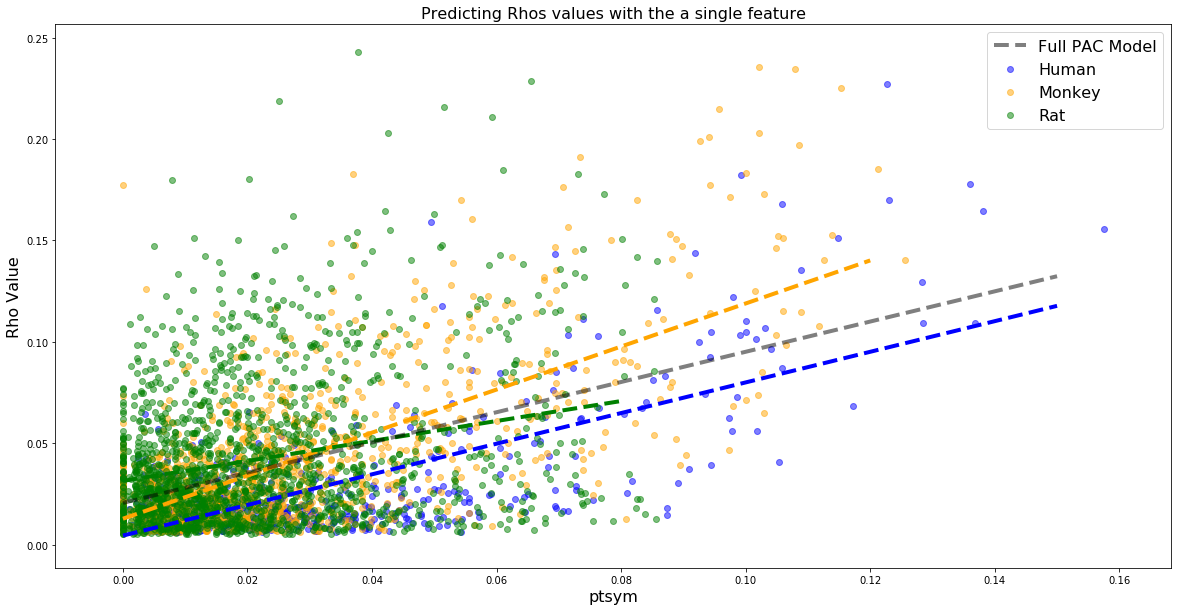

In [14]:
plt.figure(figsize=(20,10))

# Human scatter
plt.scatter(abs(features_df['human'][features_df['human']['pac_presence']==1][feature] - 0.5),
            features_df['human'][features_df['human']['pac_presence']==1]['pac_rhos'],
           color='blue', alpha =.5, label='Human')

# Monkey scatter
plt.scatter(abs(features_df['monkey'][features_df['monkey']['pac_presence']==1][feature] - 0.5),
            features_df['monkey'][features_df['monkey']['pac_presence']==1]['pac_rhos'],
           color='orange', alpha =.5, label='Monkey')

# Rat scatter
plt.scatter(abs(features_df['rat'][features_df['rat']['pac_presence']==1][feature] - 0.5),
            features_df['rat'][features_df['rat']['pac_presence']==1]['pac_rhos'],
           color='green', alpha =.5, label='Rat')



# Human regression
reg1 = linear_model.LinearRegression()
reg1.fit(feature_human, pac_rhos_human)
xs = np.arange(min(feature_human), max(feature_human),0.01)
ys = reg1.intercept_[0] + reg1.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='blue', linewidth=4, alpha=1)

# Monkey regression
reg2 = linear_model.LinearRegression()
reg2.fit(feature_monkey, pac_rhos_monkey)
xs = np.arange(min(feature_monkey), max(feature_monkey),0.01)
ys = reg2.intercept_[0] + reg2.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='orange', linewidth=4, alpha=1)

# Rat regression
reg3 = linear_model.LinearRegression()
reg3.fit(feature_rat, pac_rhos_rat)
xs = np.arange(min(feature_rat), max(feature_rat),0.01)
ys = reg3.intercept_[0] + reg3.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='green', linewidth=4, alpha=1)

# Regression model on all combined
# concatenate the three groups and reshape
pac_rhos_comb = np.reshape(np.concatenate((pac_rhos_human, pac_rhos_monkey, pac_rhos_rat), axis=None), [-1, 1])
feature_comb = np.reshape(np.concatenate((feature_human, feature_monkey, feature_rat), axis=None), [-1, 1])

# regression combo
reg4= linear_model.LinearRegression()
reg4.fit(feature_comb, pac_rhos_comb)
xs = np.arange(min(feature_comb), max(feature_comb),0.01)
ys = reg4.intercept_[0] + reg4.coef_[0][0] * xs
plt.plot(xs, ys, '--', color='black', linewidth=4, label='Full PAC Model', alpha=.5)

# 
plt.title('Predicting Rhos values with the a single feature', fontsize=16)
plt.xlabel(feature, fontsize=16)
plt.ylabel('Rho Value', fontsize=16)
plt.legend(fontsize=16)
plt.show()

 <div class="alert alert-success">
Very consistent correlation between datasets, but not yet the best way to represent. We expect the more assymetric, the higher the Rho value. We can either: use exponential regression with lowest point around 0.5 ((x - 0.5)^2), or calculate the distance from 0.5 and keep linear regression. 
</div>

 <div class="alert alert-danger">
correlations are less strong without resampling and up to 24Hz. Using data up till 14Hz shows that datapoints and correlation does not change. So big difference lies in the resampling, which basically cuts off the lower Rho values.
</div>